RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier


In [64]:
# what = 'Generic policy'
# what = 'Reporting mechanism'
what = 'Scope of practice'
# what = 'User guideline'

In [65]:
# Load datasets
df_train = pd.read_json(f'dataset/for_modeling/test_{what}.json')
df_val = pd.read_json(f'dataset/for_modeling/validation_{what}.json')
df_test = pd.read_json(f'dataset/for_modeling/test_{what}.json')

# # Load datasets
# df_train = pd.read_json(f'dataset/for_modeling/test.json')
# df_val = pd.read_json(f'dataset/for_modeling/validation.json')
# df_test = pd.read_json(f'dataset/for_modeling/test.json')

In [66]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Projects practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)

# Features
selected_features = ['num_commits', 'project_age_days', 'num_contributors', 
                     'num_issues', 'num_pull', 'num_opening_issue', 'project_size(kB)', 
                     'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers']

# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train[what]
X_val, y_val = df_val[selected_features], df_val[what]
X_test, y_test = df_test[selected_features], df_test[what]

In [67]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Random forest Classification

In [68]:
# Train Random forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None)
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.48
Validation Report:
              precision    recall  f1-score   support

           0       0.54      0.74      0.63        35
           1       0.25      0.12      0.16        25

    accuracy                           0.48        60
   macro avg       0.40      0.43      0.39        60
weighted avg       0.42      0.48      0.43        60

Test Accuracy: 1.00
Test Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        13

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



  0%|          | 0/31 [00:00<?, ?it/s]

Text(0.5, 34.62222222222221, 'Scope of practice SHAP value (KernelExplainer)')

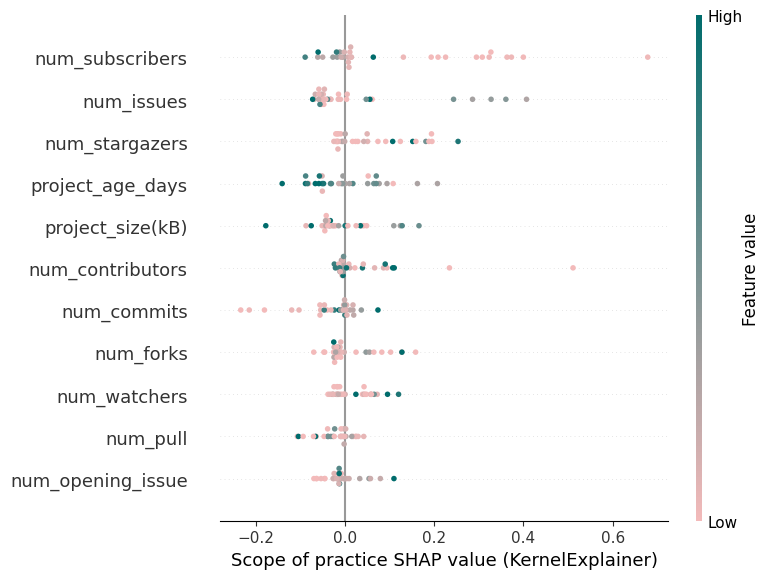

In [70]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"{what} SHAP value (KernelExplainer)")

Text(0.5, 34.62222222222221, 'Scope of practice SHAP value (TreeExplainer)')

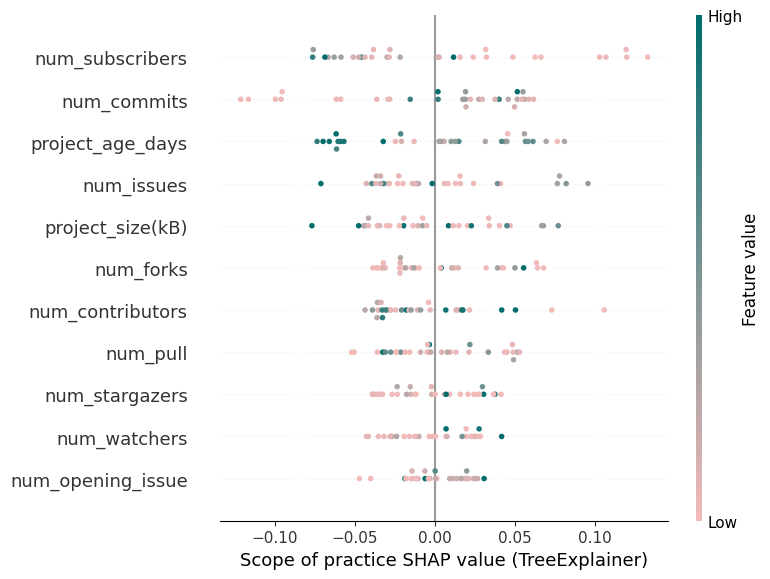

In [71]:
# Shap TreeExplainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_clf)
shap_values_rf = explainer_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf[:, :, 1], X_test, cmap=cmap, show=False)
plt.xlabel(f"{what} SHAP value (TreeExplainer)")

XGBoost Classification

In [72]:
xg_clf = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.1, objective='binary:logistic', use_label_encoder=False)
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.58
Validation Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        35
           1       0.00      0.00      0.00        25

    accuracy                           0.58        60
   macro avg       0.29      0.50      0.37        60
weighted avg       0.34      0.58      0.43        60

Test Accuracy: 0.58
Test Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        18
           1       0.00      0.00      0.00        13

    accuracy                           0.58        31
   macro avg       0.29      0.50      0.37        31
weighted avg       0.34      0.58      0.43        31



c:\Users\howto\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\howto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\howto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Text(0.5, 34.62222222222221, 'Scope of practice SHAP value')

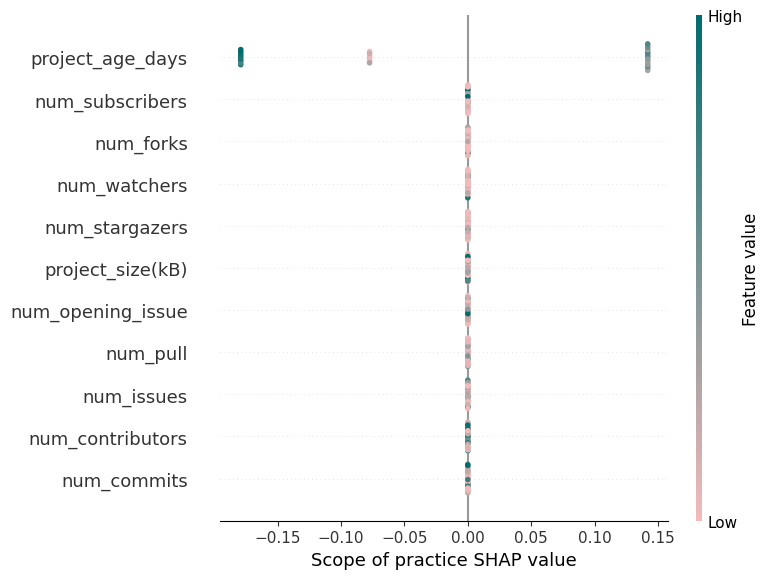

In [73]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"{what} SHAP value")

NN MLPClassifier

In [74]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic', max_iter=500)
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.47
Validation Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        35
           1       0.37      0.40      0.38        25

    accuracy                           0.47        60
   macro avg       0.46      0.46      0.46        60
weighted avg       0.47      0.47      0.47        60

Test Accuracy: 0.84
Test Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.90      0.69      0.78        13

    accuracy                           0.84        31
   macro avg       0.85      0.82      0.83        31
weighted avg       0.85      0.84      0.83        31



c:\Users\howto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Text(0.5, 34.62222222222221, 'Scope of practice SHAP value')

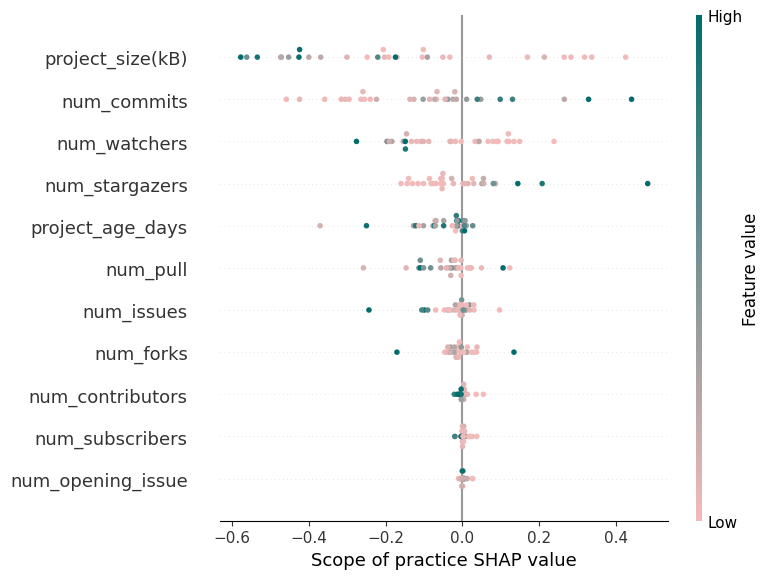

In [75]:
# Shap MLP
explainer = shap.KernelExplainer(mlp_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"{what} SHAP value")